In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define las transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descarga y carga los datos de MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Definir las transformaciones (convertir a tensor y normalizar)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descargar y cargar los datos de entrenamiento
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Descargar y cargar los datos de prueba
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [5]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Capa oculta con 128 neuronas
        self.fc2 = nn.Linear(128, 10)       # Capa de salida con 10 neuronas (una para cada dígito)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplana la imagen de 28x28 píxeles en un vector de 784 elementos
        x = F.relu(self.fc1(x))  # Activación ReLU en la capa oculta
        x = self.fc2(x)          # Capa de salida
        return x

# Instanciar el modelo
model = SimpleNN()

In [6]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Entrenar el modelo por 10 épocas
for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()           # Limpiar los gradientes
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, labels) # Calcular la pérdida
        loss.backward()                 # Backward pass
        optimizer.step()                # Actualizar los pesos

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.3538659497400125
Epoch 2, Loss: 0.17868764911194643
Epoch 3, Loss: 0.13486180202563602
Epoch 4, Loss: 0.11238550026863814
Epoch 5, Loss: 0.09630632023134579
Epoch 6, Loss: 0.08848462216680249
Epoch 7, Loss: 0.07719082523516069
Epoch 8, Loss: 0.0740953188123492
Epoch 9, Loss: 0.06641195510515632
Epoch 10, Loss: 0.0626818571860902


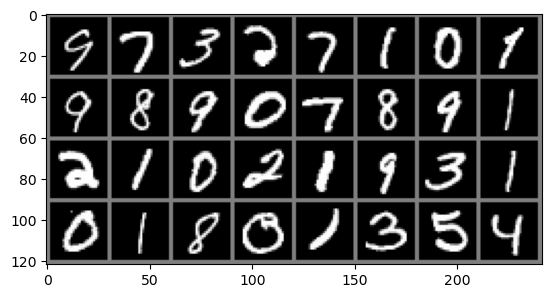

Labels: 9 7 3 2 7 1 0 1


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obtener un lote de imágenes
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar algunas imágenes
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(8)))

In [37]:
import boto3
import os

# Configura tu bucket y nombre de la carpeta
bucket_name = 'buchetchan'
folder_prefix = 'carpeta2'

# Conectar a S3
s3 = boto3.client('s3')

# Listar los objetos en la carpeta
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)

# Descargar cada archivo en la carpeta
local_folder = '/tmp/imagenes_extraidas'
os.makedirs(local_folder, exist_ok=True)

for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('/'):  # Ignorar carpetas (si hay)
        continue
    local_file_path = os.path.join(local_folder, os.path.basename(key))
    s3.download_file(bucket_name, key, local_file_path)

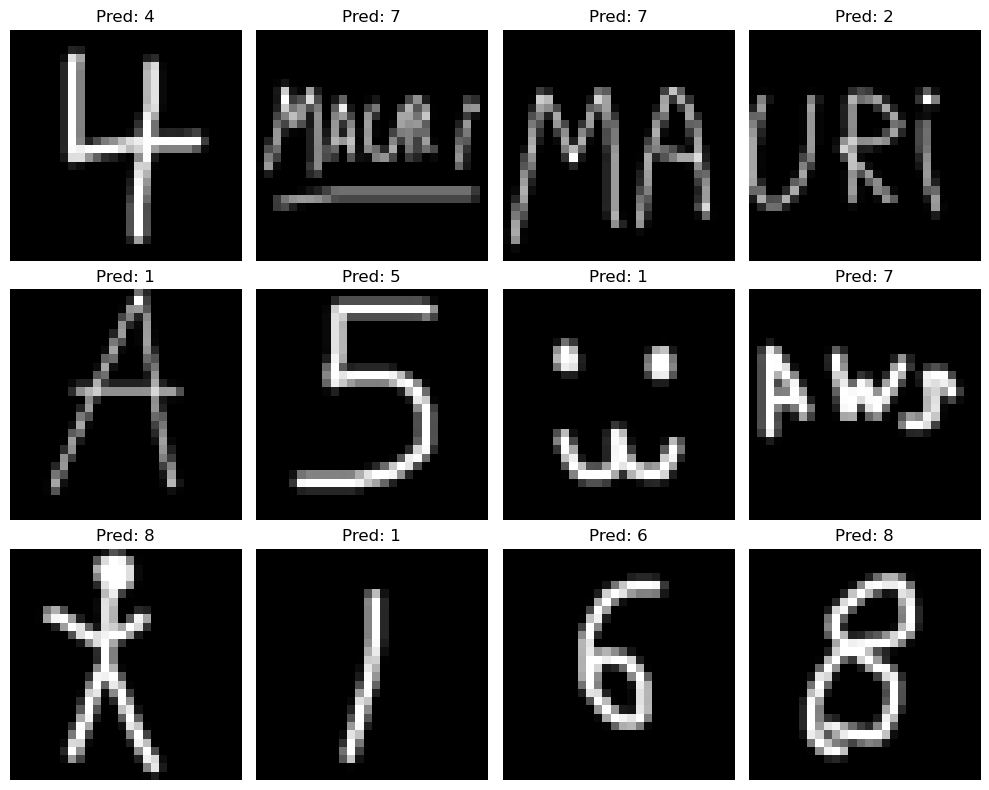

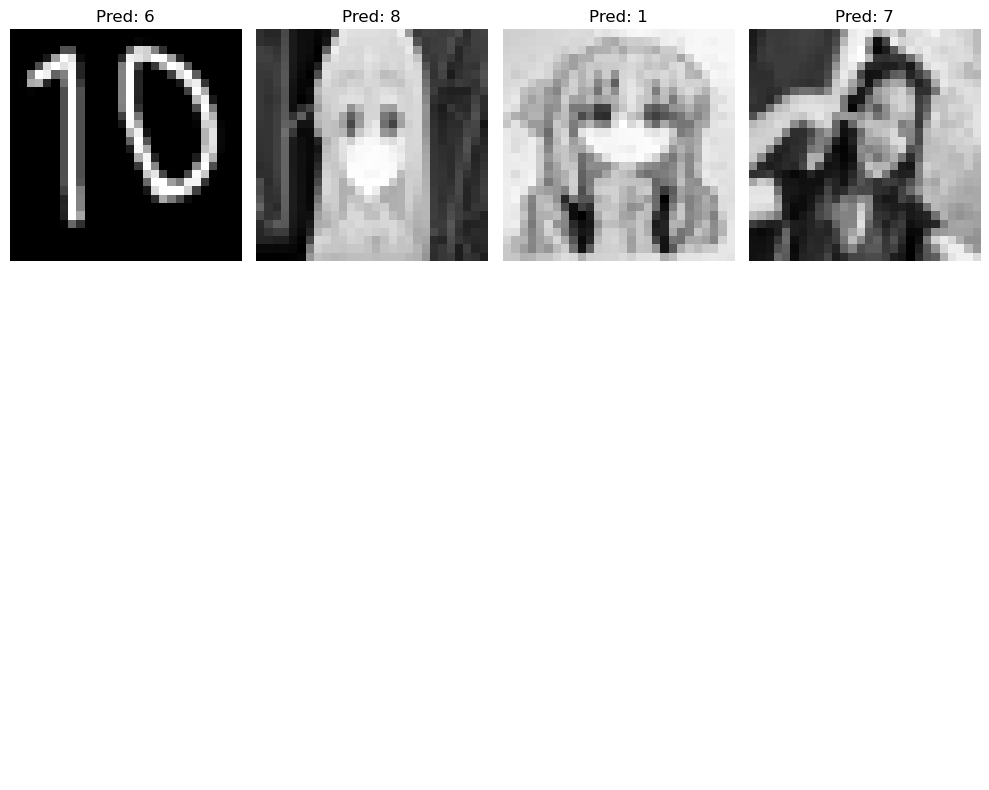

In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os

# Función para cargar y procesar la imagen
def load_and_process_image(img_path):
    img = Image.open(img_path).convert('L')  # Convertir a escala de grises
    img = img.resize((28, 28))  # Redimensionar a 28x28
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Función para mostrar las imágenes en cuadrículas de 3x4
def show_image_grid(images, preds, rows=3, cols=4):
    num_images = len(images)
    
    for start in range(0, num_images, rows * cols):
        # Crear una cuadrícula de 3x4 (12 imágenes por cuadrícula)
        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
        for i in range(rows * cols):
            img_index = start + i
            if img_index >= num_images:
                axes[i // cols, i % cols].axis('off')
                continue
            img, pred = images[img_index], preds[img_index]
            axes[i // cols, i % cols].imshow(img, cmap='gray')
            axes[i // cols, i % cols].set_title(f'Pred: {pred}', fontsize=12)
            axes[i // cols, i % cols].axis('off')
        
        plt.tight_layout()
        plt.show()

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Directorio de las imágenes descargadas
local_folder = '/tmp/imagenes_extraidas'

# Listas para almacenar las imágenes y predicciones
images = []
preds = []

# Procesar cada imagen en la carpeta
for img_file in os.listdir(local_folder):
    img_path = os.path.join(local_folder, img_file)
    img, img_tensor = load_and_process_image(img_path)
    
    # Añadir la imagen a la lista
    images.append(img)

    # Realizar la predicción
    model.eval()
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    preds.append(predicted.item())

# Mostrar las imágenes en cuadrículas de 12 por página
show_image_grid(images, preds)
